In [1]:
import import_ipynb
import common_notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, f1_score, fbeta_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

importing Jupyter notebook from common_notebook.ipynb


In [2]:
# Imports from common_notebook
process = common_notebook.process
get_data = common_notebook.get_data
mean = common_notebook.mean
std = common_notebook.std
as_dict = common_notebook.as_dict
MAINTAINABILITY_COLUMNS = common_notebook.MAINTAINABILITY_COLUMNS
METRIC_COLUMNS = common_notebook.METRIC_COLUMNS
METRIC_COLUMNS_LOC = common_notebook.METRIC_COLUMNS_LOC

# Replication de la maintanability 

In [3]:
#Dataset
dataset = get_data()

#True = non maintenable  /   False = maintenable
dataset['target'] = ((dataset[MAINTAINABILITY_COLUMNS[0]] + dataset[MAINTAINABILITY_COLUMNS[1]])
                > (dataset[MAINTAINABILITY_COLUMNS[2]] + dataset[MAINTAINABILITY_COLUMNS[3]]))


In [4]:
#set
X = dataset[METRIC_COLUMNS]
y = dataset['target']

X = X.values

#### Classification

In [5]:
#The best model from the replication of The Schnapinger study
BinaryClassifier = AdaBoostClassifier(n_estimators=150, learning_rate=0.5)
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=33)

In [6]:
# List to store the predicted probabilities of each fold
probabilities_list = []

# List to store the AUC-ROC scores of each fold
auc_scores = []

# List to store the mean FPRs and TPRs
fprs = []
tprs = []

# Mean of the probabilities
proba_moyenne = []

# List to store the AUC-ROC scores
auc_scores = []

# List to store the F1 scores
f1_scores = []

# List to store the F2 scores
f2_scores = []

# List to store the F0.5 scores
f05_scores = []

In [7]:
# Training the Model
for i, (train_index, test_index) in enumerate(kf.split(X)):
    # Split the data into training and test sets for this fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Train the model on the training set
    BinaryClassifier.fit(X_train, y_train)
    
    # Performance metric values
    y_pred = BinaryClassifier.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    f2 = fbeta_score(y_test, y_pred, beta=2)
    f05 = fbeta_score(y_test, y_pred, beta=0.5)
    f1_scores.append(f1)
    f2_scores.append(f2)
    f05_scores.append(f05)

    # Obtain the predicted probabilities for the positive class
    y_proba = BinaryClassifier.predict_proba(X_test)[:, 1]
  
    # Store the predicted probabilities in a list with a unique variable name
    variable_name = f'v{i+1}'
    exec(f"{variable_name} = y_proba")
    
    # Add the predicted probabilities to the list
    probabilities_list.append(y_proba)
    #proba_moyenne.append(mean(y_proba))

    # Calculate the AUC-ROC score for this fold
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    
    fprs.append(fpr)
    tprs.append(tpr)

    roc_auc_scores = auc(fpr, tpr)
    auc_scores.append(roc_auc_scores)


C:\Users\user\AppData\Local\Temp\ipykernel_19720\1631063806.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train, y_test = y[train_index], y[test_index]
C:\Users\user\AppData\Local\Temp\ipykernel_19720\1631063806.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train, y_test = y[train_index], y[test_index]
C:\Users\user\AppData\Local\Temp\ipykernel_19720\1631063806.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_tr

[0.         0.05555556 0.07692308 0.09090909 0.125      0.15384615
 0.16666667 0.18181818 0.1875     0.25       0.27272727 0.36363636
 0.375      0.5        0.63636364 1.        ]


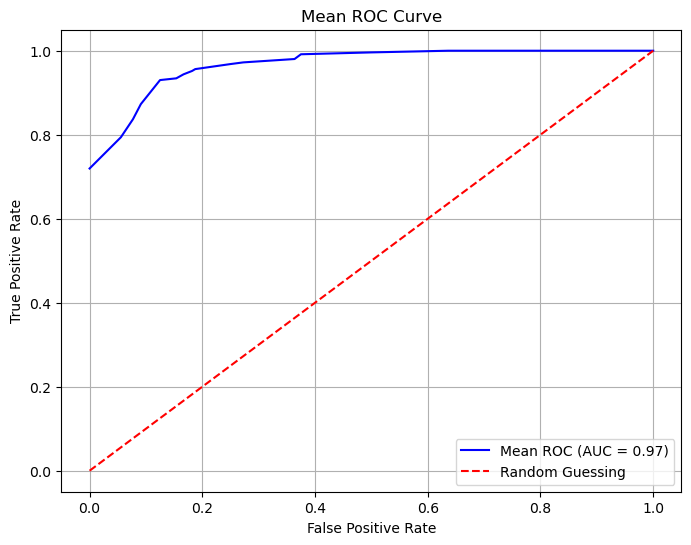

In [8]:
# Initialize a list to store all FPR points
all_fpr = []

# Add all FPR points to the list
for fpr in fprs:
    all_fpr.append(fpr)

# Sort the FPR points
all_fpr_sorted = np.sort(np.unique(np.concatenate(all_fpr)))

print(all_fpr_sorted)
# Compute the mean TPR for each FPR
mean_tpr = np.zeros_like(all_fpr_sorted, dtype=float)
for fpr, tpr in zip(fprs, tprs):
    mean_tpr += np.interp(all_fpr_sorted, fpr, tpr)

mean_tpr /= len(fprs)

# Calculate the AUC of the mean ROC curve
mean_auc = auc(all_fpr_sorted, mean_tpr)

# Plot the mean ROC curve
plt.figure(figsize=(8, 6))
plt.plot(all_fpr_sorted, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f})')

# Plot the dashed line representing the random guessing diagonal
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Guessing')

# Add labels and a legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mean ROC Curve')
plt.legend()
plt.grid(True)

# Display the mean ROC curve
plt.show()


# Markus

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from sklearn.metrics import roc_auc_score

In [10]:
df = pd.read_csv('masterfile-2024.csv', sep=';')
df['ground_truth'] = df['Overall'].apply(lambda x: True if x >= 2 else False)
#True = non-maintainable, i.e., a file that is a problem to maintain
#False = maintainable file, i.e., a file that is not a problem to maintain

In [28]:
def get_codescene_matrix(df, CH_lowest=2, CH_highest=10.01, CH_stepsize=0.01):
    """
    Classifies each file as 'maintainable' or 'not maintainable' based on the code_health score.
    The classification result for each threshold is stored in a new column in a new DataFrame.
    
    Parameters:
    - df: Pandas DataFrame containing the files data.
    - CH_lowest: The lowest threshold of code_health to consider.
    - CH_highest: The highest threshold of code_health to consider.
    - CH_stepsize: The step size to increment the threshold.
    
    Returns:
    - df_codescene: A new DataFrame with each column representing a classification result at each threshold.
    """
    
    # Ensure code_health is numeric
    df['code_health'] = pd.to_numeric(df['code_health'], errors='coerce')
    
    # Initialize an empty DataFrame to store classification results
    df_codescene = pd.DataFrame(index=df.index)
    
    # Generate thresholds
    thresholds = np.arange(CH_lowest, CH_highest + CH_stepsize, CH_stepsize)
    print('combien de valeurs dans la liste' , thresholds.shape)

    # Classify at each threshold
    for threshold in thresholds:
        # Column name indicating the threshold
        column_name = f"CH_{threshold:.3f}"
        # Apply classification based on current threshold
        df_codescene[column_name] = df['code_health'].apply(lambda x: True if x < threshold else False)
        
    return df_codescene

In [29]:
def get_sonarqube_ratio_matrix(df, ratio_lowest=0, ratio_highest=0.4, ratio_stepsize=0.005):
    """
    Classifies each file as 'maintainable' or 'not maintainable' based on the TD_ratio.
    The classification result for each threshold is stored in a new column in a new DataFrame.
    """
    
    # Ensure code_health is numeric
    df['TD_ratio'] = pd.to_numeric(df['TD_ratio'], errors='coerce')
    
    # Initialize an empty DataFrame to store classification results
    df_sonarqube_ratio = pd.DataFrame(index=df.index)
    
    # Generate thresholds
    thresholds = np.arange(ratio_lowest, ratio_highest + ratio_stepsize, ratio_stepsize)
    
    # Classify at each threshold
    for threshold in thresholds:
        # Column name indicating the threshold
        column_name = f"ratio_{threshold:.3f}"
        # Apply classification based on current threshold
        df_sonarqube_ratio[column_name] = df['TD_ratio'].apply(lambda x: True if x >= threshold else False)
        
    return df_sonarqube_ratio

In [30]:
def get_sonarqube_time_matrix(df, time_lowest=0, time_highest=1800, time_stepsize=5):
    """
    Classifies each file as 'maintainable' or 'not maintainable' based on the estimated remediation time.
    The classification result for each threshold is stored in a new column in a new DataFrame.
    """
    
    # Ensure code_health is numeric
    df['TD_time'] = pd.to_numeric(df['TD_time'], errors='coerce')
    
    # Initialize an empty DataFrame to store classification results
    df_sonarqube_time = pd.DataFrame(index=df.index)
    
    # Generate thresholds
    thresholds = np.arange(time_lowest, time_highest + time_stepsize, time_stepsize)
   
    # Classify at each threshold
    for threshold in thresholds:
        # Column name indicating the threshold
        column_name = f"time_{threshold}"
        # Apply classification based on current threshold
        df_sonarqube_time[column_name] = df['TD_time'].apply(lambda x: True if x >= threshold else False)
        
    return df_sonarqube_time

In [31]:
def get_loc_matrix(df, loc_lowest=0, loc_highest = 2444, loc_stepsize= 10):
    """
    Classifies each file as 'maintainable' or 'not maintainable' based on the TD_ratio.
    The classification result for each threshold is stored in a new column in a new DataFrame.
    """
    
    # Ensure code_health is numeric
    df['nos'] = pd.to_numeric(df['nos'], errors='coerce')
    
    # Initialize an empty DataFrame to store classification results
    df_loc = pd.DataFrame(index=df.index)
    
    # Generate thresholds
    thresholds = np.arange(loc_lowest, loc_highest + loc_stepsize, loc_stepsize)
    
    # Classify at each threshold
    for threshold in thresholds:
        # Column name indicating the threshold
        column_name = f"ratio_{threshold:.3f}"
        # Apply classification based on current threshold
        df_loc[column_name] = df['nos'].apply(lambda x: False if x >= threshold else True)    #False == maintainable & True == non maintainable 
        
    return df_loc

In [32]:
df_codescene = get_codescene_matrix(df)
df_sonarqube_ratio = get_sonarqube_ratio_matrix(df)
df_sonarqube_time = get_sonarqube_time_matrix(df)
df_loc = get_loc_matrix(common_notebook.get_data())

combien de valeurs dans la liste (802,)


C:\Users\user\AppData\Local\Temp\ipykernel_19720\133970662.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_codescene[column_name] = df['code_health'].apply(lambda x: True if x < threshold else False)
C:\Users\user\AppData\Local\Temp\ipykernel_19720\133970662.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_codescene[column_name] = df['code_health'].apply(lambda x: True if x < threshold else False)
C:\Users\user\AppData\Local\Temp\ipykernel_19720\133970662.py:31: PerformanceWarning: DataFrame is highly fragmented. 

In [73]:
df_sonarqube_ratio 

,ratio_0.000,ratio_0.005,ratio_0.010,ratio_0.015,ratio_0.020,ratio_0.025,ratio_0.030,ratio_0.035,ratio_0.040,ratio_0.045,ratio_0.050,ratio_0.055,ratio_0.060,ratio_0.065,ratio_0.070,ratio_0.075,ratio_0.080,ratio_0.085,ratio_0.090,ratio_0.095,ratio_0.100,ratio_0.105,ratio_0.110,ratio_0.115,ratio_0.120,ratio_0.125,ratio_0.130,ratio_0.135,ratio_0.140,ratio_0.145,ratio_0.150,ratio_0.155,ratio_0.160,ratio_0.165,ratio_0.170,ratio_0.175,ratio_0.180,ratio_0.185,ratio_0.190,ratio_0.195,ratio_0.200,ratio_0.205,ratio_0.210,ratio_0.215,ratio_0.220,ratio_0.225,ratio_0.230,ratio_0.235,ratio_0.240,ratio_0.245,ratio_0.250,ratio_0.255,ratio_0.260,ratio_0.265,ratio_0.270,ratio_0.275,ratio_0.280,ratio_0.285,ratio_0.290,ratio_0.295,ratio_0.300,ratio_0.305,ratio_0.310,ratio_0.315,ratio_0.320,ratio_0.325,ratio_0.330,ratio_0.335,ratio_0.340,ratio_0.345,ratio_0.350,ratio_0.355,ratio_0.360,ratio_0.365,ratio_0.370,ratio_0.375,ratio_0.380,ratio_0.385,ratio_0.390,ratio_0.395,ratio_0.400
0,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False

In [18]:
def calculate_tpr_fpr_at_thresholds(df, df_pred, ground_truth_column):
    """
    Calculates TPR and FPR for each threshold classification in df_codescene,
    using a specified ground truth column from the original dataframe.
    """
    binary_ground_truth = df[ground_truth_column].astype(int)
    
    tpr_fpr_scores = {}
    for column in df_pred.columns:
        binary_predictions = df_pred[column].astype(int)
        
        # Calculate True Positives (TP), False Positives (FP), True Negatives (TN), and False Negatives (FN)
        TP = ((binary_predictions == 1) & (binary_ground_truth == 1)).sum()
        FP = ((binary_predictions == 1) & (binary_ground_truth == 0)).sum()
        TN = ((binary_predictions == 0) & (binary_ground_truth == 0)).sum()
        FN = ((binary_predictions == 0) & (binary_ground_truth == 1)).sum()
        
        # Avoid division by zero
        if (TP + FN) == 0 or (FP + TN) == 0:
            print(f"Skipping {column} due to division by zero in TPR or FPR calculation.")
            continue
        
        # Calculate TPR and FPR
        TPR = TP / (TP + FN)
        FPR = FP / (FP + TN)
        
        tpr_fpr_scores[column] = {'TPR': TPR, 'FPR': FPR}
        
    return tpr_fpr_scores

In [19]:
tpr_fpr_codescene = calculate_tpr_fpr_at_thresholds(df, df_codescene, "ground_truth")
tpr_fpr_sonarqube_ratio = calculate_tpr_fpr_at_thresholds(df, df_sonarqube_ratio, "ground_truth")
tpr_fpr_sonarqube_time = calculate_tpr_fpr_at_thresholds(df, df_sonarqube_time, "ground_truth")
tpr_fpr_loc = calculate_tpr_fpr_at_thresholds(dataset, df_loc, "target")  #revoir target

In [20]:
# Extracting TPR and FPR values along with their corresponding thresholds
thresholds_codescene = [float(th.split('_')[1]) for th in tpr_fpr_codescene.keys()]
tpr_values_codescene = [vals['TPR'] for vals in tpr_fpr_codescene.values()]
fpr_values_codescene = [vals['FPR'] for vals in tpr_fpr_codescene.values()]

thresholds_sonarqube_ratio = [float(th.split('_')[1]) for th in tpr_fpr_sonarqube_ratio.keys()]
tpr_values_sonarqube_ratio = [vals['TPR'] for vals in tpr_fpr_sonarqube_ratio.values()]
fpr_values_sonarqube_ratio = [vals['FPR'] for vals in tpr_fpr_sonarqube_ratio.values()]

thresholds_sonarqube_time = [float(th.split('_')[1]) for th in tpr_fpr_sonarqube_time.keys()]
tpr_values_sonarqube_time = [vals['TPR'] for vals in tpr_fpr_sonarqube_time.values()]
fpr_values_sonarqube_time = [vals['FPR'] for vals in tpr_fpr_sonarqube_time.values()]

thresholds_loc = [float(th.split('_')[1]) for th in tpr_fpr_loc.keys()]
tpr_values_loc = [vals['TPR'] for vals in tpr_fpr_loc.values()]
fpr_values_loc = [vals['FPR'] for vals in tpr_fpr_loc.values()]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.015151515151515152,
 0.015151515151515152,
 0.015151515151515152,
 0.015151515151515152,
 0.015151515151515152,
 0.015151515151515152,
 0.015151515151515152,
 0.015151515151515152,
 0.015151515151515152,
 0.015151515151515152,
 0.015151515151515152,
 0.015151515151515152,
 0.015151515151515152,
 0.015151515151515152,
 0.015151515151515152,
 0.015151515151515152,
 0.015151515151515152,
 0.015151515151515152,
 0.015151515151515152,
 0.015151515151515152,
 0.015151515151515152,
 0.015151515151515152,
 0.015151515151515152,
 0.015151515151515152,
 0.015151515151515152,
 0.015151515151515152,
 0.015151515151515152,
 0.015151515151515152,
 0.015151515151515152,
 0.015151515151515152,
 0.015151515151515152,
 0.015151515151515152,
 0.015151515151515152,
 0.015151515151515152,
 0.015151515151515152,
 0.015151515151515152

In [55]:
#Key Points
tpr_point_codescene = tpr_values_codescene[df_codescene.columns.get_loc('CH_9.000')]
fpr_point_codescene = fpr_values_codescene[df_codescene.columns.get_loc('CH_9.000')]

tpr_point_sonarqube_ratio = tpr_values_codescene[df_sonarqube_ratio.columns.get_loc('ratio_0.050')]
fpr_point_sonarqube_ratio = fpr_values_codescene[df_sonarqube_ratio.columns.get_loc('ratio_0.050')]

print("Codescene: ", (fpr_point_codescene, tpr_point_codescene))
print("SonarQube: ", (fpr_point_sonarqube_ratio, tpr_point_sonarqube_ratio ))

Codescene:  (0.025210084033613446, 0.7727272727272727)
SonarQube:  (0.0, 0.0)


### ROC Curves

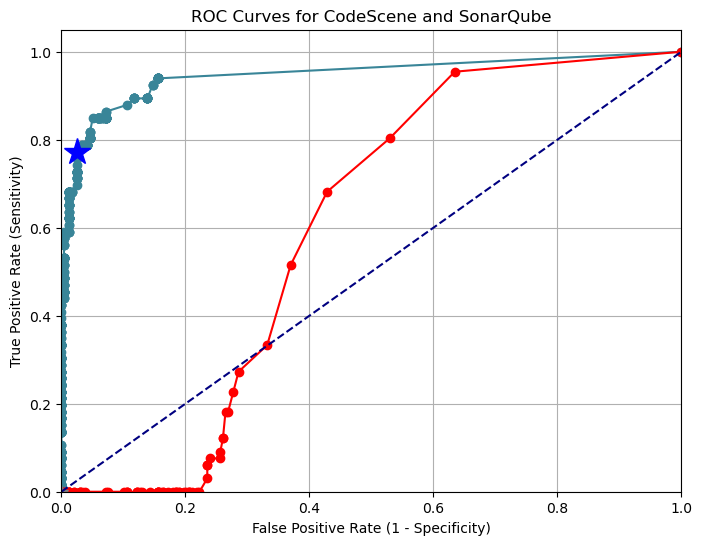

In [63]:
# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_values_codescene, tpr_values_codescene, marker='o', linestyle='-', color='#398598', label='Code Health')
#plt.plot(fpr_values_sonarqube_time, tpr_values_sonarqube_time, marker='o', linestyle='-', color='green', label='SonarQube TD Time')
plt.plot(fpr_values_sonarqube_ratio, tpr_values_sonarqube_ratio, marker='o', linestyle='-', color='red', label='SonarQube TD Ratio')

#plt.plot(all_fpr_sorted, mean_tpr, marker='o', color='orange', label=f'Mean ROC (AUC = {mean_auc:.2f})')

#plt.plot(fpr_values_loc, tpr_values_loc, marker='o', linestyle='-', color='brown', label='Line Of Code ')


plt.plot(fpr_point_codescene, tpr_point_codescene, marker='*', color='blue', markersize=20, label=f'Code Health 9.0 ({fpr_point_codescene}, {tpr_point_codescene})')
plt.plot(fpr_point_sonarqube_ratio, tpr_point_sonarqube_ratio, marker='*', color='grey', markersize=10, label=f'SonarQube ratio 5% ({fpr_point_sonarqube_ratio}, {tpr_point_sonarqube_ratio})')




# Plotting the diagonal line from (0,0) to (1,1)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curves for CodeScene and SonarQube')
#plt.legend(loc="lower right")
plt.grid(True)
plt.show()